# IMPORT PACKAGES

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
from datetime import timedelta
import time

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# READ DATA INTO PANDAS

In [2]:
Transactions = pd.read_csv('E-Commerce-Transaction.csv')
Transactions.head(3)

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom


# OVERVIEW OF DATASET

In [3]:
Transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  536350 non-null  object 
 1   Date           536350 non-null  object 
 2   ProductNo      536350 non-null  object 
 3   ProductName    536350 non-null  object 
 4   Price          536350 non-null  float64
 5   Quantity       536350 non-null  int64  
 6   CustomerNo     536295 non-null  float64
 7   Country        536350 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.7+ MB


In [4]:
Shape_0 = Transactions.shape[0]
Shape_1 = Transactions.shape[1]

print('COMMENT:')
print(f'There are {Shape_0} customer transactions in the dataset')
print(f'There are {Shape_1} columns in the dataset')

COMMENT:
There are 536350 customer transactions in the dataset
There are 8 columns in the dataset


# Custom Functions For Downstream Analysis

# 1. Function for extracting date parts

In [5]:
def date_parts(DF):
    
    """
    This function returns different date parts as new columns in the dataframe.
    
    Args:
    
        DF: Pandas DataFrame of interest
    
    """
    
    # Get day name of month
    DF['Day_name_of_month'] = DF['Date'].dt.day_name()

    #Get day of the week as integer
    DF['Day_as_integer'] = DF['Date'].dt.dayofweek

    #Get date of the month 
    DF['Day_of_month'] = DF['Date'].dt.day

    #Get month of the year
    DF['Month_of_the_year'] = DF['Date'].dt.month
    
    #Get month name of the year
    DF['Month_name'] = DF['Date'].dt.month_name()

    #Get year of the date
    DF['Year'] = DF['Date'].dt.year

    #Check for week in the year
    DF['Week_of_the_year'] = DF['Date'].dt.isocalendar().week


# 2. Custom function for growth performance

In [6]:
def performance(DF, col1, col2, xlabel, ylabel, title):
    
    """
    
    This function returns performance of sales over a specified time period.
    
    Args:
    
        DF: Pandas DataFrame of interest.
    
        col1 : Date column of interest. Should be passed in as string.
    
        col2: Date column of interest. Should be passed in as string.
    
        xlabel: Label on the x-axis
    
        ylabel: Label on the y-axis
    
        title: Title of plot
    
    """
    
    data = DF.groupby(col1).sum(col2).reset_index().sort_values(col2)
    
    plt.figure(figsize = (10,8))
    
    sns.barplot(x = col1, y = col2, data = data, color = 'indianred', ci = False)
    
    plt.xlabel(xlabel)
    
    plt.xticks(rotation=90)
    
    plt.ylabel(ylabel)
    
    plt.title(title)
    
    plt.show()
    

# 3. Custom function that checks for percentage missing values in the dataset

In [7]:
def nan_checker(DF):
    
    """
    This function returns percentage of mising values in the dataframe
    
    Args: 
    
        DF: Pandas DataFrame of interest.
    
    """
    
    Total = DF.isnull().sum().sort_values(ascending = False)
    
    Percent = DF.isnull().sum()/DF.isnull().count()*100
    
    Missing_data = pd.concat([Total, Percent], axis = 1, keys = ['Total_Null', 'Percentage'])
    
    return Missing_data


# 4. custom function to check outliers

In [8]:
def outlier_detector(DF, col):
    
    """
    
    This function returns values that lie at a great distance from the rest of the values in the data. This is outlier/anomaly
    
    Args:
    
        DF : Pandas DataFrame of interest
    
        col: Column holding datapoints whose outliers are to be gotten. The column name should be passed in as string.
    
    """
    
    #Get percentiles
    percentiles25 = DF[col].quantile(0.25)
    percentiles75 = DF[col].quantile(0.75)
    
    #Get interquartile value
    IQR = percentiles75 - percentiles25
    
    #Get upper and lower limits
    upperbound = percentiles75 + 1.5*IQR
    lowerbound = percentiles25 - 1.5*IQR
    
    #Filter DataFrame to find outliers
    return DF[(DF[col] > upperbound)|(DF[col] < lowerbound )]
    

# 5. Custom Function to check preferred products based on order volume

In [9]:
def product_preferred(DF, product, quantity):
    
    """
    This function visualizes top 5 products that are ordered 
    
    Args:
    
        DF: Pandas DataFrame
    
        product: Column holding names of products bought. Should be passed in as string.
        
        quantity : Column holding quantity of product ordered. Should be passed in as string.
    
    """
    #Filter out cancelled transactions
    Data = DF[~DF['TransactionNo'].str.contains('C')]
    
    #Get total quantity ordered for each product 
    Product = Data.groupby(product)[quantity].sum().reset_index().sort_values(quantity, ascending = False)
    
    #Filter for top 5 products ordered and visualize
    Top5_Product = Product.iloc[:5]
    sns.barplot(x = product, y = quantity, data = Top5_Product, color = 'indianred')
    plt.xlabel('Product')
    plt.xticks(rotation = 90)
    plt.ylabel('Total Quantity Sold')
    plt.title('TOP 5 ORDRERD PRODUCTS ')
    plt.show()



# 6. Custom function to check products receiving the most cancellation

In [10]:
def product_cancelled(DF, product, quantity):
    
    """
    This function visualizes top 5 products that got cancelled 
    
    Args:
    
        DF: Pandas DataFrame
    
        product: Column holding names of products bought. Should be passed in as string.
    
        quantity : Column holding quantity of product ordered. Should be passed in as string.
    
    """
    #Filter out cancelled transactions
    data = DF[DF['TransactionNo'].str.contains('C')]
    
    #Create column holding quantity ordered as positive values
    data[quantity] = data[quantity].abs()
    
    #Get total quantity ordered for each product 
    Product = data.groupby(product)[quantity].sum().reset_index().sort_values(quantity, ascending = False)
    
    #Filter for top 5 products cancelled and visualize
    Top5_Product = Product.iloc[:5]
    sns.barplot(x = product, y = quantity, data = Top5_Product, color = 'indianred')
    plt.xlabel('Product')
    plt.xticks(rotation = 90)
    plt.ylabel('Total Quantity Cancelled')
    plt.title('TOP 5 CANCELLED PRODUCTS ')
    plt.show()



# 7. Custom function to check transaction pattern of each customer segment

In [11]:
def Transaction_pattern(DF):
    
    """
    This function returns total number of transactions, number of completed orders, number of cancelled orders, amount spent
    by each customer.
    
    Args:
    
        DF: Pandas DataFrame of interest
    
    """

    #Number of transactions for each customer

    customers_trans = DF["CustomerNo"].value_counts().reset_index()

    #Number of completed transactions and cancelled transactions for each customer

    customers_transcount = DF.groupby("CustomerNo")["Cancelled"].value_counts().unstack()

    customers_transcount_df = customers_transcount.reset_index()

    # Total amount paid by each customer

    customers_price = DF.groupby("CustomerNo")["Price"].sum().reset_index()

    #Merge The Three DataFrames

    Customer_info = pd.merge(customers_trans, customers_transcount_df, left_on = 'index', right_on = 'CustomerNo')

    Customer_Information = Customer_info.merge(customers_price, left_on = 'index', right_on = 'CustomerNo')

    # Rename columns
 
    Customer_Information.rename(columns={'index': 'CustomerNo', 'cancelled': 'Cancelled_Orders', 'completed': 'Completed_Orders', 'CustomerNo_x':'Total_Transactions', 'Price':'Total_Amount'}, inplace = True)

    # Drop CustomerNo_y

    Customer_Information.drop('CustomerNo_y', axis = 1, inplace = True)

    return Customer_Information.fillna(0)
    

# 8. Custom function to check for transaction summary analysis

In [12]:
def transaction_summary(DF, transactions, cancelled, completed, amount):
    
    """
    This function returns number of customers in customer segments, and average transaction performance.
    
    Args:
    
        DF : Pandas DataFrame
    
        transactions: returns average number of transactions. Pass column name as string
    
        cancelled : column holding information on cancelled orders. Pass column name as sting
    
        completed : column holding values on completed transactions. Pass column name as string
    
        amount: column holding information on money spent. Pass column name as string
    
    """
    print( 'Total number of customers is  : ', DF.shape[0])
    print('----------------------------------------------')
    print('Average number of transactions is : ', DF[transactions].median())
    print('----------------------------------------------')
    print('Average number of cancelled orders is : ', DF[cancelled].median())
    print('----------------------------------------------')
    print('Average number of completed orders is : ', DF[completed].median())
    print('----------------------------------------------')
    print('Average amount spent is : ', DF[amount].median())
    print('----------------------------------------------')
    print('Highest amount spent : ', DF[amount].max())
    print('----------------------------------------------')
    print('Lowest amount spent : ', DF[amount].min())
    

# Date Column

In [13]:
Transactions['Date'] = pd.to_datetime(Transactions['Date'], infer_datetime_format = True, errors ='coerce')

Transactions['Date']

0        2019-12-09
1        2019-12-09
2        2019-12-09
3        2019-12-09
4        2019-12-09
            ...    
536345   2018-12-01
536346   2018-12-01
536347   2018-12-01
536348   2018-12-01
536349   2018-12-01
Name: Date, Length: 536350, dtype: datetime64[ns]

# Extract Datetime Parts 

In [14]:
date_parts(Transactions)

In [15]:
Transactions.head(2)

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Day_name_of_month,Day_as_integer,Day_of_month,Month_of_the_year,Month_name,Year,Week_of_the_year
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,Monday,0,9,12,December,2019,50
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,Monday,0,9,12,December,2019,50


# Add Amount Spent Column
Which is the total amount spent for each transaction

In [16]:
Transactions['Amount_Spent'] = Transactions['Price'] * Transactions['Quantity']

Transactions.head(3)

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Day_name_of_month,Day_as_integer,Day_of_month,Month_of_the_year,Month_name,Year,Week_of_the_year,Amount_Spent
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,Monday,0,9,12,December,2019,50,257.64
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,Monday,0,9,12,December,2019,50,383.40
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,Monday,0,9,12,December,2019,50,138.36


# Add column, 'Cancelled' -- 
Information on whether order was cancelled or completed


In [17]:
#Create column, Cancelled which holds information on whether customer cancelled order or not

Transactions["Cancelled"] = Transactions["TransactionNo"].apply( lambda x: "cancelled" if x.startswith("C") else "completed")

# Check For Missing Values

In [18]:
nan_checker(Transactions)

,Total_Null,Percentage
CustomerNo,55,0.010254
TransactionNo,0,0.000000
Day_as_integer,0,0.000000
Amount_Spent,0,0.000000
Week_of_the_year,0,0.000000
Year,0,0.000000
Month_name,0,0.000000
Month_of_the_year,0,0.000000
Day_of_month,0,0.000000
Day_name_of_month,0,0.000000


# The number of missing values is not significant, so we will drop it 

In [19]:
Transactions.dropna(inplace = True)

In [20]:
#Use function on dataframe to check for missing values

nan_checker(Transactions)

,Total_Null,Percentage
TransactionNo,0,0.0
Day_as_integer,0,0.0
Amount_Spent,0,0.0
Week_of_the_year,0,0.0
Year,0,0.0
Month_name,0,0.0
Month_of_the_year,0,0.0
Day_of_month,0,0.0
Day_name_of_month,0,0.0
Date,0,0.0


# Duplicate Analysis

In [21]:
# Number of duplicates
Transactions.duplicated(keep = 'first').sum()

5200

# Comment:
    
There are 5,200 duplicate values. These duplicates will be dropped to prevent having misleading analysis results

In [22]:
# Duplicate values
Transactions[Transactions.duplicated(keep = False)].sort_values(by = ['TransactionNo', 'ProductName'])

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Day_name_of_month,Day_as_integer,Day_of_month,Month_of_the_year,Month_name,Year,Week_of_the_year,Amount_Spent,Cancelled
533724,536409,2018-12-01,22866,Hand Warmer Scotty Dog Design,12.40,1,17908.0,United Kingdom,Saturday,5,1,12,December,2018,48,12.40,completed
533761,536409,2018-12-01,22866,Hand Warmer Scotty Dog Design,12.40,1,17908.0,United Kingdom,Saturday,5,1,12,December,2018,48,12.40,completed
533720,536409,2018-12-01,22111,Scottie Dog Hot Water Bottle,15.32,1,17908.0,United Kingdom,Saturday,5,1,12,December,2018,48,15.32,completed
533771,536409,2018-12-01,22111,Scottie Dog Hot Water Bottle,15.32,1,17908.0,United Kingdom,Saturday,5,1,12,December,2018,48,15.32,completed
533756,536409,2018-12-01,22900,Set 2 Tea Towels I Love London,13.27,1,17908.0,United Kingdom,Saturday,5,1,12,December,2018,48,13.27,completed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102612,C574510,2019-11-04,22360,Glass Jar English Confectionery,13.27,-1,15110.0,United Kingdom,Monday,0,4,11,November,2019,45,-13.27,cancelled
80075,C575940,2019-11-13,23309,Set Of 60 I Love London Cake Cases,10.81,-24,17838.0,United Kingdom,Wednesday,2,13,11,November,2019,46,-259.44,cancelled
80076,C575940,2019-11-13,23309,Set Of 60 I Love London Cake Cases,10.81,-24,17838.0,United Kingdom,Wednesday,2,13,11,November,2019,46,-259.44,cancelled
12213,C580764,2019-12-06,22667,Recipe Box Retrospot,6.19,-12,14562.0,United Kingdom,Friday,4,6,12,December,2019,49,-74.28,cancelled


In [23]:
# Drop duplicates

Transactions = Transactions.drop_duplicates(keep = 'first')

# Total Number Of Transactions

In [24]:
Transactions['TransactionNo'].nunique()

23168

# Number Of Unique Products

In [25]:
Transactions['ProductName'].nunique()

3767

# Number Of Cancelled Products

In [26]:
Cancelled = Transactions['TransactionNo'].str.contains('C').sum()

In [27]:
Percent_cancelled = ((Cancelled/Transactions.shape[0])*100).sum()

print('COMMENT: ')
print(f'Approximately {round(Percent_cancelled, 2)}% of total transactions got cancelled ')
print('Customer review should be analyzed, and the products receiving the most cancellation should be reviewed')

COMMENT: 
Approximately 1.6% of total transactions got cancelled 
Customer review should be analyzed, and the products receiving the most cancellation should be reviewed


# Most Cancelled Products

In [28]:
Cancelled = Transactions['TransactionNo'].str.contains('C')

Cancelled_transactions = Transactions[Cancelled].sort_values('Quantity', ascending = True)

Cancelled_transactions[['Month_name','Year','ProductName', 'Quantity', 'Amount_Spent', 'Country']]

,Month_name,Year,ProductName,Quantity,Amount_Spent,Country
1616,December,2019,Paper Craft Little Birdie,-80995,-501359.05,United Kingdom
475332,January,2019,Medium Ceramic Top Storage Jar,-74215,-840113.80,United Kingdom
533232,December,2018,Rotating Silver Angels T-Light Hldr,-9360,-96220.80,United Kingdom
378552,April,2019,Fairy Cake Flannel Assorted Colour,-3114,-38613.60,United Kingdom
378551,April,2019,Gin And Tonic Diet Metal Sign,-2000,-24300.00,United Kingdom
...,...,...,...,...,...,...
207656,September,2019,Pink Regency Teacup And Saucer,-1,-13.27,United Kingdom
207655,September,2019,Roses Regency Teacup And Saucer,-1,-13.27,United Kingdom
207651,September,2019,Dairy Maid Traditional Teapot,-1,-17.37,United Kingdom
378560,April,2019,Please One Person Metal Sign,-1,-12.15,United Kingdom


# Total Quantity of each product ordered

In [29]:
Transactions_complete = Transactions.copy()
Transactions_complete['Quantity_ordered'] = Transactions['Quantity'].abs()
Transactions_complete.groupby(['Month_name','Year', 'Country', 'ProductName'])['Quantity_ordered'].sum().reset_index()\
                       .sort_values('Quantity_ordered', ascending = False)

,Month_name,Year,Country,ProductName,Quantity_ordered
18153,December,2019,United Kingdom,Paper Craft Little Birdie,161990
28373,January,2019,United Kingdom,Medium Ceramic Top Storage Jar,148430
54597,November,2019,United Kingdom,Asstd Design 3d Paper Stickers,12551
56250,November,2019,United Kingdom,Popcorn Holder,12318
14765,December,2018,United Kingdom,Rotating Silver Angels T-Light Hldr,11639
...,...,...,...,...,...
52671,November,2019,Iceland,Ceramic Pirate Chest Money Bank,1
52664,November,2019,Iceland,Card Holder Love Bird Large,1
52660,November,2019,Iceland,Camouflage Ear Muff Headphones,1
52657,November,2019,Iceland,Cakes And Rabbits Design Flannel,1


# Comment:
Product with the highest number of cancelled orders is Paper Craft Little Birdie. 80,995 units out of 161990 orders from the United Kingdom got cancelled.

For products whose orders got cancelled, customer reviews on the product should be analyzed to understand reason for cancellation. This will enable coming up with strategies to reduce cancellation of the products, and thereby reduce loss for the company.

In [30]:
# Set Date as index
Transactions_dt_index = Transactions.copy()

Transactions_dt_index.set_index(['Date'], inplace = True)

# Sales In Terms Of Order Volume

In [31]:
# Best Sales Month

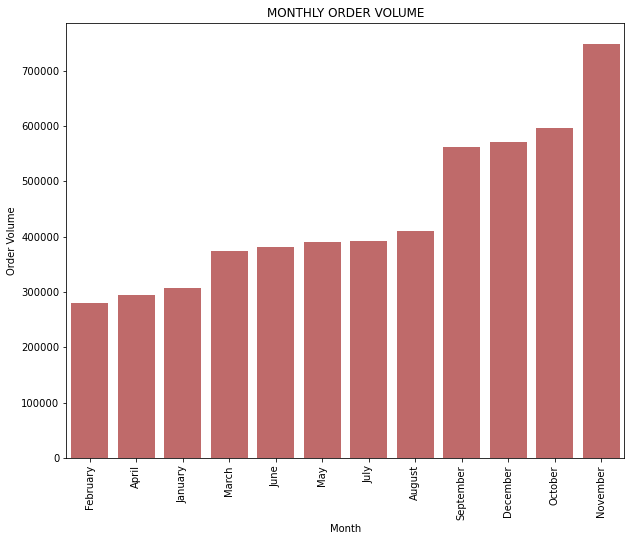

In [32]:
Month_OV_Performance = performance(Transactions, 'Month_name', 'Quantity', 'Month', 'Order Volume', 'MONTHLY ORDER VOLUME')
Month_OV_Performance

In [33]:
# Best Sales Day

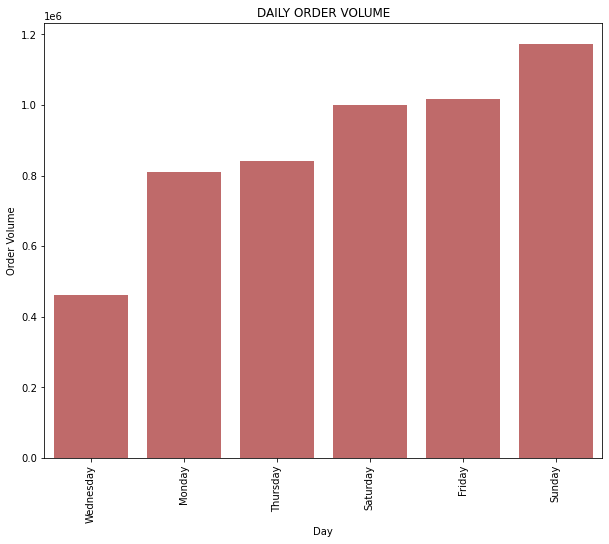

In [34]:
Day_OV_Performance = performance(Transactions, 'Day_name_of_month', 'Quantity', 'Day', 'Order Volume', 'DAILY ORDER VOLUME')
Day_OV_Performance

# Month Over Month Order Volume Performance

In [35]:
Total_Monthly_OrderVolume = Transactions_dt_index['Quantity'].resample('M').sum()

Total_Monthly_OrderVolume

Date
2018-12-31    341585
2019-01-31    306617
2019-02-28    280016
2019-03-31    373317
2019-04-30    293917
2019-05-31    390523
2019-06-30    381888
2019-07-31    392934
2019-08-31    409631
2019-09-30    561872
2019-10-31    597287
2019-11-30    748507
2019-12-31    229216
Freq: M, Name: Quantity, dtype: int64

# Month Over Month Sales Growth Rate Performance

In [36]:
Total_Monthly_Growth_Rate_OV = Total_Monthly_OrderVolume.pct_change()

Total_Monthly_Growth_Rate_OV

Date
2018-12-31         NaN
2019-01-31   -0.102370
2019-02-28   -0.086756
2019-03-31    0.333199
2019-04-30   -0.212688
2019-05-31    0.328685
2019-06-30   -0.022111
2019-07-31    0.028925
2019-08-31    0.042493
2019-09-30    0.371654
2019-10-31    0.063030
2019-11-30    0.253178
2019-12-31   -0.693769
Freq: M, Name: Quantity, dtype: float64

# Sales In Terms Of Revenue Generated

In [37]:
# Best Sales Month

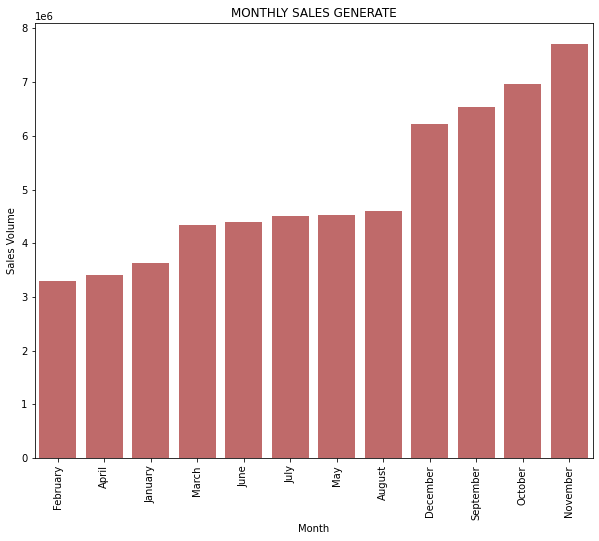

In [38]:
performance(Transactions, 'Month_name', 'Amount_Spent', 'Month', 'Sales Volume', 'MONTHLY SALES GENERATE')


In [39]:
# Best Sales Day

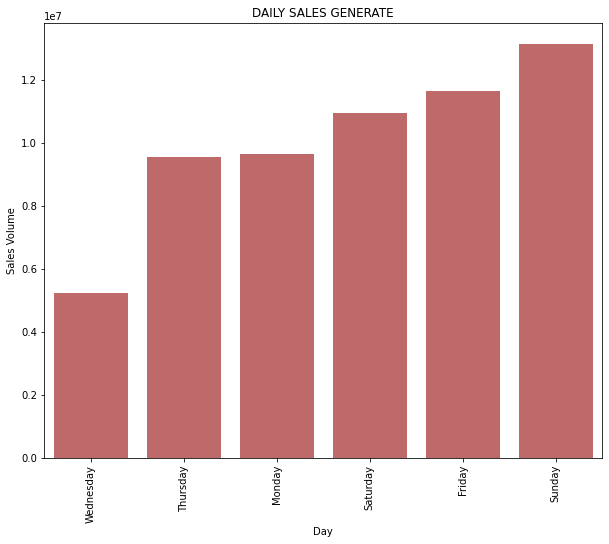

In [40]:
Day_RG_Performance = performance(Transactions, 'Day_name_of_month', 'Amount_Spent', 'Day', 'Sales Volume',
                                 \'DAILY SALES GENERATE')
Day_RG_Performance

In [41]:
# Month Over Month Sales Performance

In [42]:
Total_Monthly_Sales = Transactions_dt_index['Amount_Spent'].resample('M').sum()

Total_Monthly_Sales

Date
2018-12-31    4217281.53
2019-01-31    3638948.12
2019-02-28    3292324.69
2019-03-31    4340035.60
2019-04-30    3406002.17
2019-05-31    4521986.96
2019-06-30    4404297.96
2019-07-31    4501972.15
2019-08-31    4609655.77
2019-09-30    6529427.35
2019-10-31    6965035.30
2019-11-30    7712905.93
2019-12-31    1994715.74
Freq: M, Name: Amount_Spent, dtype: float64

In [43]:
# Month Over Month Sales Growth Rate Performance

In [44]:
Total_Monthly_Growth_Rate = Total_Monthly_Sales.pct_change()

Total_Monthly_Growth_Rate

Date
2018-12-31         NaN
2019-01-31   -0.137134
2019-02-28   -0.095254
2019-03-31    0.318228
2019-04-30   -0.215213
2019-05-31    0.327652
2019-06-30   -0.026026
2019-07-31    0.022177
2019-08-31    0.023919
2019-09-30    0.416467
2019-10-31    0.066715
2019-11-30    0.107375
2019-12-31   -0.741379
Freq: M, Name: Amount_Spent, dtype: float64

# Product Performance

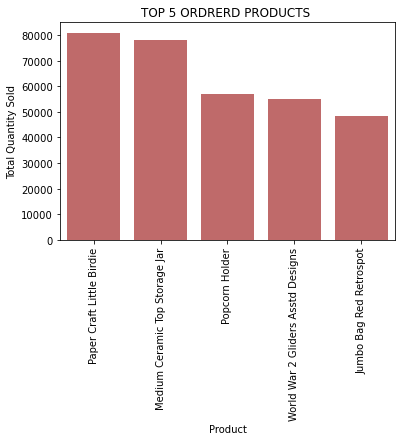

In [45]:
product_preferred(Transactions, 'ProductName', 'Quantity')

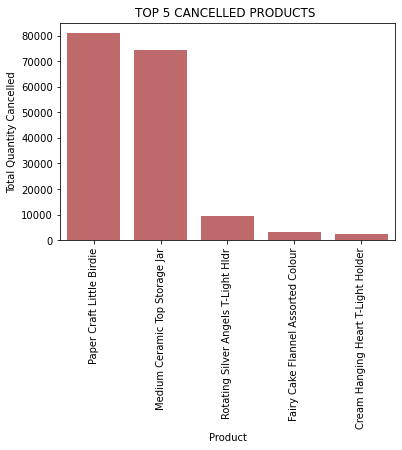

In [46]:
product_cancelled(Transactions, 'ProductName', 'Quantity')

# Sales Performance By Country -- Revenue Generated

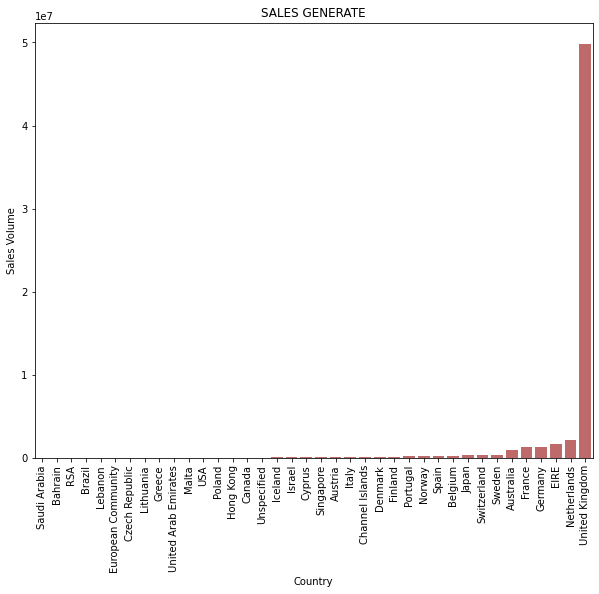

In [47]:
Country = performance(Transactions, 'Country', 'Amount_Spent', 'Country', 'Sales Volume', 'SALES GENERATE')
Country

# CUSTOMER SEGMENTATION ANALYSIS - RFM METRIC

#Filter out cancelled transactions. It will not be needed, being that we are interested in how valuable a customer is. For this reason, quantity of goods bought, total amount spent per transactions has to be positive values.


In [48]:
Transactions_RFM = Transactions[~Transactions['TransactionNo'].str.contains('C')].copy()

In [49]:
Transactions_RFM.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Day_name_of_month,Day_as_integer,Day_of_month,Month_of_the_year,Month_name,Year,Week_of_the_year,Amount_Spent,Cancelled
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,Monday,0,9,12,December,2019,50,257.64,completed
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,Monday,0,9,12,December,2019,50,383.40,completed
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,Monday,0,9,12,December,2019,50,138.36,completed
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom,Monday,0,9,12,December,2019,50,127.80,completed
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom,Monday,0,9,12,December,2019,50,71.64,completed


# Date Span Of Data

In [50]:
#check date span of data

mindate = Transactions['Date'].min()

print('Earliest transaction is : ', mindate)

Earliest transaction is :  2018-12-01 00:00:00


In [51]:
#check date span of data

maxdate = Transactions['Date'].max()

print('Latest transaction is : ', maxdate)

Latest transaction is :  2019-12-09 00:00:00


In [52]:
timeframe = maxdate - mindate

print('Span of date in data being used is: ', timeframe)

Span of date in data being used is:  373 days 00:00:00


#In the real-world, we will be working with the most recent snapshot of the data, which is today or yesterday. But,in this case, the data comes from 2018-2019, so we have to create a hypothetical snapshot date that we will use as a starting point to calculate metrics as if we are doing the analysis on the most recent data.

In [53]:
#Let us create our snapshot date
td = timedelta(days = 1)
snapshot_date = maxdate + td

In [54]:
# Customer shopping habit

Shopping_habit = Transactions_RFM.groupby(['CustomerNo']).agg({'Date': lambda x:(snapshot_date-x.max()).days,
                                               'TransactionNo':'count',
                                               'Amount_Spent':'sum'})

In [55]:
# Rename columns

Shopping_habit.rename(columns = {'Date':'Recency','TransactionNo':'Frequency','Amount_Spent':'MonetaryValue'}, inplace = True)

In [56]:
Shopping_habit.head()

,Recency,Frequency,MonetaryValue
CustomerNo,,,
12004.0,228,56,1509.60
12006.0,219,1,24.76
12008.0,277,203,5689.57
12013.0,360,1,69.96
12024.0,177,5,149.52


# RFM Metric

BUILDING RFM SEGMENTS USING QUARTILES

QUARTILES

Q1 -- LOWEST QUARTILE(lowest 25% of data)

Q2--- MIDDLE QUARTILE(25% TO 50% of data)

Q3---- MIDDLE QUARTILE(50% to 75% of data)

Q4---- HIGHEST QUARTILE(highest 25% of data(75-100% of data))

#Recency metric

In recency, we want a customer to be active in most recent time possible. This shows the customer is still likely to remain with us, since the customer is still here. So, a low value will be a good recency value.
pd.qcut() segments data by default into quartiles, Q1 being assigned to the lowest value and Q4 being assigned to the largest value. So when labeling our recency data, we will asign our labels in such a way that the higher value(higher number of days since last purchase) will be given a low quartile recency score of 1(not recent), and lower value(lower number of days since last patronage), a higher quartile recency value(4)

In [57]:
# Get quartiles and labels

r_label = range(4,0,-1)

r_quartiles = pd.qcut(Shopping_habit['Recency'], 4, labels = r_label)

#Assign these values to the Shopping_habit dataframe

Shopping_habit = Shopping_habit.assign(R = r_quartiles.values)

Shopping_habit

,Recency,Frequency,MonetaryValue,R
CustomerNo,,,,
12004.0,228,56,1509.60,1
12006.0,219,1,24.76,1
12008.0,277,203,5689.57,1
12013.0,360,1,69.96,1
12024.0,177,5,149.52,1
...,...,...,...,...
18280.0,278,10,623.26,1
18281.0,181,7,576.58,1
18282.0,8,12,1044.86,4


In [58]:
# Get quartiles and labels

f_labels = range(1,5)

m_labels = range(1,5)

f_quartiles = pd.qcut(Shopping_habit['Frequency'], 4, labels = f_labels)

m_quartiles = pd.qcut(Shopping_habit['MonetaryValue'], 4, labels = m_labels)


In [59]:
#Assign labels to the dataframe

Shopping_habit = Shopping_habit.assign(F = f_quartiles)

Shopping_habit= Shopping_habit.assign(M = m_quartiles)

Shopping_habit

,Recency,Frequency,MonetaryValue,R,F,M
CustomerNo,,,,,,
12004.0,228,56,1509.60,1,3,1
12006.0,219,1,24.76,1,1,1
12008.0,277,203,5689.57,1,4,3
12013.0,360,1,69.96,1,1,1
12024.0,177,5,149.52,1,1,1
...,...,...,...,...,...,...
18280.0,278,10,623.26,1,1,1
18281.0,181,7,576.58,1,1,1
18282.0,8,12,1044.86,4,1,1


# Anomaly Analysis

In [60]:
RFM_df = Shopping_habit[['Recency', 'Frequency', 'MonetaryValue']]

RFM_df

,Recency,Frequency,MonetaryValue
CustomerNo,,,
12004.0,228,56,1509.60
12006.0,219,1,24.76
12008.0,277,203,5689.57
12013.0,360,1,69.96
12024.0,177,5,149.52
...,...,...,...
18280.0,278,10,623.26
18281.0,181,7,576.58
18282.0,8,12,1044.86


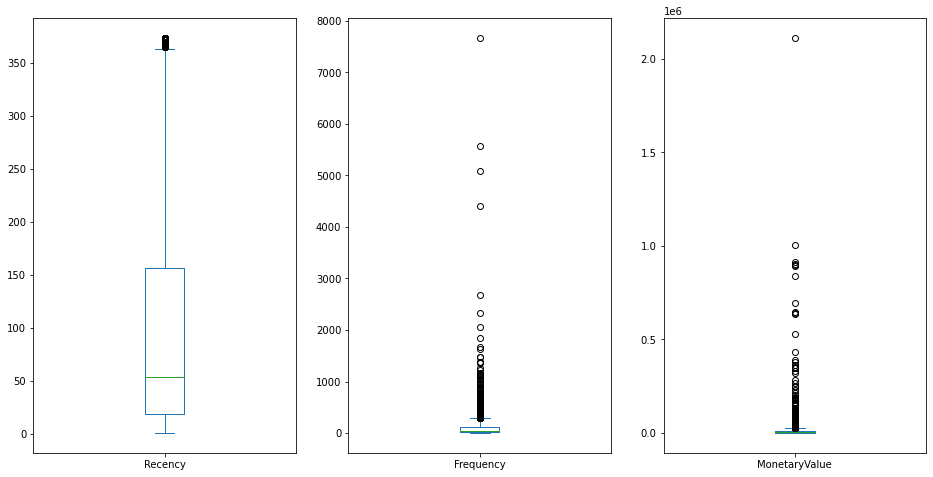

In [61]:
RFM_df.plot(subplots = True, kind = 'box', layout = (1, 3), figsize = (16, 8))

plt.show()

#  Comment:

There are lots of outliers in Frequency and MonetaryValue, so they will be investigated

# Customers whose frequency of purchasing is an anomaly 

In [62]:
outlier_detector(Shopping_habit, 'Frequency')

,Recency,Frequency,MonetaryValue,R,F,M
CustomerNo,,,,,,
12026.0,340,409,20486.32,1,4,4
12067.0,18,485,14293.33,4,4,4
12071.0,366,647,23189.62,1,4,4
12115.0,9,712,14211.47,4,4,4
12237.0,369,596,22960.43,1,4,4
...,...,...,...,...,...,...
18109.0,2,440,47445.09,4,4,4
18116.0,68,367,9794.11,2,4,3
18118.0,11,1257,32912.56,4,4,4


# Customers whose MonetaryValue is an anomaly

In [63]:
outlier_detector(Shopping_habit, 'MonetaryValue')

,Recency,Frequency,MonetaryValue,R,F,M
CustomerNo,,,,,,
12346.0,326,1,840113.80,1,1,4
12347.0,3,785,38307.42,4,4,4
12357.0,34,130,33893.72,3,4,4
12370.0,52,165,27585.33,3,4,4
12378.0,130,219,29410.60,2,4,4
...,...,...,...,...,...,...
18198.0,5,159,46294.34,4,4,4
18223.0,5,271,33450.55,4,4,4
18225.0,4,269,34292.60,4,4,4


# RFM SEGMENT 

In [64]:
Shopping_habit['RFM_segment'] = Shopping_habit['R'].astype(str) + Shopping_habit['F'].astype(str) + \
                                                                                    Shopping_habit['M'].astype(str)

In [65]:
# Create a segmentation map
segmentation_map = {r'444' : 'Champions',
                   r'[3-4][4][1-3]' : 'Loyal customer',
                   r'[3-4][2-3][1-3]': 'Potential loyalist',
                   r'[2-3][3-4][4]' : 'Potential champions',
                   r'3[2-4][3-4]': 'Potential champions',
                   r'434' : 'Potential champions',
                   r'4[1-2][1-4]' : 'Recent customer',
                   r'[1-3][1-2][2-4]' : 'Need attention',
                   r'311' : 'Need attention',
                   r'[1-2][3-4][1-4]' : 'At risk',
                   r'[1-2][4][4]' : 'Cannot lose',
                   r'[1-2][1-2][1-4]': 'Hibernating',
                   r'111' : 'Lost customer'}

Shopping_habit['Customer_segment'] = Shopping_habit['RFM_segment'].replace(segmentation_map, regex = True)
Shopping_habit.head(3)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,Customer_segment
CustomerNo,,,,,,,,
12004.0,228,56,1509.60,1,3,1,131,At risk
12006.0,219,1,24.76,1,1,1,111,Hibernating
12008.0,277,203,5689.57,1,4,3,143,At risk


In [66]:
Shopping_habit['Customer_segment'].unique()

array(['At risk', 'Hibernating', 'Loyal customer', 'Champions',
       'Need attention', 'Potential loyalist', 'Potential champions',
       'Recent customer'], dtype=object)

In [67]:
# Reset index

Shopping_habit.reset_index(inplace = True)

# Get Average Recency , Frequency, Monetary values For The Customer Base 

In [68]:
print('The average Recency of customers in the customer base is: ', Shopping_habit['Recency'].median())
print('The average Frequency of customers in the customer base is: ', Shopping_habit['Frequency'].median())
print('The average MonetaryValue of customers in the customer base is: ', Shopping_habit['MonetaryValue'].median())


The average Recency of customers in the customer base is:  54.0
The average Frequency of customers in the customer base is:  50.0
The average MonetaryValue of customers in the customer base is:  4804.425


Median was used as the measure of central tendency because the presence of outliers in these columns, as seen in the boxplot for anomaly detection.

# Get Average Recency , Frequency, Monetary Values For Each Customer Segment In The Customer Base 

In [69]:
Shopping_habit.groupby('Customer_segment').agg({'Recency':'median', 'Frequency':'median', 'MonetaryValue':'median'})

,Recency,Frequency,MonetaryValue
Customer_segment,,,
At risk,152.0,86.0,6259.855
Champions,6.0,303.0,27081.900
Hibernating,217.0,10.0,872.905
Loyal customer,19.0,191.0,7908.580
Need attention,100.0,20.0,3108.035
Potential champions,34.0,130.0,18146.220
Potential loyalist,22.0,52.0,4484.720
Recent customer,10.0,11.0,1299.340


Median was used as the measure of central tendency because the presence of outliers in these columns, as seen in the boxplot for anomaly detection.

# Merge 'Shopping_habit To Main DataFrame

In [70]:
Transactions_df = Transactions.merge(Shopping_habit, on = 'CustomerNo', how = 'inner')
Transactions_df.head(3)

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Day_name_of_month,Day_as_integer,...,Amount_Spent,Cancelled,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,Customer_segment
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,Monday,0,...,257.64,completed,1,76,13538.07,4,3,4,434,Potential champions
1,581481,2019-12-09,21115,Rose Caravan Doorstop,12.25,8,17490.0,United Kingdom,Monday,0,...,98.00,completed,1,76,13538.07,4,3,4,434,Potential champions
2,581481,2019-12-09,22059,Ceramic Strawberry Design Mug,10.65,24,17490.0,United Kingdom,Monday,0,...,255.60,completed,1,76,13538.07,4,3,4,434,Potential champions


# Subset For The Different Customer Types

# 1. Champions

In [71]:
Champions = Transactions_df[Transactions_df['Customer_segment'] == 'Champions']
Champions.head(3)

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Day_name_of_month,Day_as_integer,...,Amount_Spent,Cancelled,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,Customer_segment
85,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,Monday,0,...,383.40,completed,1,424,63226.14,4,4,4,444,Champions
86,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,Monday,0,...,138.36,completed,1,424,63226.14,4,4,4,444,Champions
87,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom,Monday,0,...,127.80,completed,1,424,63226.14,4,4,4,444,Champions


# 2. Loyal  Customer

In [72]:
Loyal_customer = Transactions_df[Transactions_df['Customer_segment'] == 'Loyal customer']
Loyal_customer.head(3)

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Day_name_of_month,Day_as_integer,...,Amount_Spent,Cancelled,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,Customer_segment
5842,581502,2019-12-09,22087,Paper Bunting White Lace,7.24,6,15910.0,United Kingdom,Monday,0,...,43.44,completed,1,268,9999.26,4,4,3,443,Loyal customer
5843,581502,2019-12-09,21209,Multicolour Honeycomb Fan,7.24,5,15910.0,United Kingdom,Monday,0,...,36.20,completed,1,268,9999.26,4,4,3,443,Loyal customer
5844,581502,2019-12-09,20668,Disco Ball Christmas Decoration,7.24,24,15910.0,United Kingdom,Monday,0,...,173.76,completed,1,268,9999.26,4,4,3,443,Loyal customer


# 3. Potential Loyalist

In [73]:
Potential_loyalist = Transactions_df[Transactions_df['Customer_segment'] == 'Potential loyalist']
Potential_loyalist.head(3)

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Day_name_of_month,Day_as_integer,...,Amount_Spent,Cancelled,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,Customer_segment
1542,581480,2019-12-09,23464,Vintage Zinc Watering Can Small,15.32,4,14441.0,United Kingdom,Monday,0,...,61.28,completed,1,51,6326.48,4,3,3,433,Potential loyalist
1543,581480,2019-12-09,22411,Jumbo Shopper Vintage Red Paisley,12.38,10,14441.0,United Kingdom,Monday,0,...,123.80,completed,1,51,6326.48,4,3,3,433,Potential loyalist
1544,581480,2019-12-09,84029E,Red Woolly Hottie White Heart,14.61,8,14441.0,United Kingdom,Monday,0,...,116.88,completed,1,51,6326.48,4,3,3,433,Potential loyalist


# 4. Potential champions

In [74]:
Potential_champions = Transactions_df[Transactions_df['Customer_segment'] == 'Potential champions']
Potential_champions.head(3)

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Day_name_of_month,Day_as_integer,...,Amount_Spent,Cancelled,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,Customer_segment
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,Monday,0,...,257.64,completed,1,76,13538.07,4,3,4,434,Potential champions
1,581481,2019-12-09,21115,Rose Caravan Doorstop,12.25,8,17490.0,United Kingdom,Monday,0,...,98.00,completed,1,76,13538.07,4,3,4,434,Potential champions
2,581481,2019-12-09,22059,Ceramic Strawberry Design Mug,10.65,24,17490.0,United Kingdom,Monday,0,...,255.60,completed,1,76,13538.07,4,3,4,434,Potential champions


# 5. Recently customer

In [75]:
Recent_customer = Transactions_df[Transactions_df['Customer_segment'] == 'Recent customer']
Recent_customer.head(3)

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Day_name_of_month,Day_as_integer,...,Amount_Spent,Cancelled,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,Customer_segment
1601,581483,2019-12-09,23843,Paper Craft Little Birdie,12.38,80995,16446.0,United Kingdom,Monday,0,...,1002718.10,completed,1,3,1002741.57,4,1,4,414,Recent customer
1602,C581484,2019-12-09,23843,Paper Craft Little Birdie,6.19,-80995,16446.0,United Kingdom,Monday,0,...,-501359.05,cancelled,1,3,1002741.57,4,1,4,414,Recent customer
1603,553573,2019-05-18,22980,Pantry Scrubbing Brush,11.94,1,16446.0,United Kingdom,Saturday,5,...,11.94,completed,1,3,1002741.57,4,1,4,414,Recent customer


# 6. Need Attention

In [76]:
Need_attention = Transactions_df[Transactions_df['Customer_segment'] == 'Need attention']
Need_attention.head(3)

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Day_name_of_month,Day_as_integer,...,Amount_Spent,Cancelled,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,Customer_segment
111667,C580954,2019-12-06,22333,Retrospot Party Bag + Sticker Set,6.19,-32,12967.0,United Kingdom,Friday,4,...,-198.08,cancelled,197,20,6207.75,1,2,3,123,Need attention
111668,C580954,2019-12-06,22276,Wash Bag Vintage Rose Paisley,6.19,-6,12967.0,United Kingdom,Friday,4,...,-37.14,cancelled,197,20,6207.75,1,2,3,123,Need attention
111669,C580954,2019-12-06,22128,Party Cones Candy Assorted,6.19,-42,12967.0,United Kingdom,Friday,4,...,-259.98,cancelled,197,20,6207.75,1,2,3,123,Need attention


# 7.  At risk 

In [77]:
At_risk = Transactions_df[Transactions_df['Customer_segment'] == 'At risk']
At_risk.head(3)

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Day_name_of_month,Day_as_integer,...,Amount_Spent,Cancelled,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,Customer_segment
64371,C581323,2019-12-08,21533,Retrospot Large Milk Jug,6.19,-1,14442.0,Channel Islands,Sunday,6,...,-6.19,cancelled,205,63,6569.88,1,3,3,133,At risk
64372,C554688,2019-05-25,22637,Piggy Bank Retrospot,12.86,-1,14442.0,Channel Islands,Saturday,5,...,-12.86,cancelled,205,63,6569.88,1,3,3,133,At risk
64373,C554688,2019-05-25,23092,Large Antique White Photo Frame,18.35,-1,14442.0,Channel Islands,Saturday,5,...,-18.35,cancelled,205,63,6569.88,1,3,3,133,At risk


# 8. Cannot lose

In [78]:
Cannot_lose = Transactions_df[Transactions_df['Customer_segment'] == 'Cannot lose']
Cannot_lose.head(3)

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Day_name_of_month,Day_as_integer,...,Amount_Spent,Cancelled,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,Customer_segment


# 9.  Hibernating

In [79]:
Hibernating = Transactions_df[Transactions_df['Customer_segment'] == 'Hibernating']
Hibernating.head(3)

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Day_name_of_month,Day_as_integer,...,Amount_Spent,Cancelled,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,Customer_segment
90654,C581128,2019-12-07,85099B,Jumbo Bag Red Retrospot,6.19,-3,12785.0,Portugal,Saturday,5,...,-18.57,cancelled,365,13,1221.82,1,1,1,111,Hibernating
90655,538311,2018-12-10,21931,Jumbo Storage Bag Suki,12.25,10,12785.0,Portugal,Monday,0,...,122.50,completed,365,13,1221.82,1,1,1,111,Hibernating
90656,538311,2018-12-10,22759,Set Of 3 Notebooks In Parcel,11.94,12,12785.0,Portugal,Monday,0,...,143.28,completed,365,13,1221.82,1,1,1,111,Hibernating


# 10. Lost customer

In [80]:
Lost_customer = Transactions_df[Transactions_df['Customer_segment'] == 'Lost customer']
Lost_customer.head(3)

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Day_name_of_month,Day_as_integer,...,Amount_Spent,Cancelled,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,Customer_segment


# Transaction Pattern Of The Different Customer Segments

# 1. Champions information

In [81]:
Champions_info = Transaction_pattern(Champions)
Champions_info

,CustomerNo,Total_Transactions,Cancelled_Orders,Completed_Orders,CustomerNo,Total_Amount
0,17841.0,7803,132.0,7671.0,17841.0,91848.87
1,14911.0,5794,220.0,5574.0,14911.0,74644.83
2,14096.0,5093,0.0,5093.0,14096.0,61085.92
3,12748.0,4456,43.0,4413.0,12748.0,48547.16
4,14606.0,2751,81.0,2670.0,14606.0,34272.71
...,...,...,...,...,...,...
430,16496.0,132,2.0,130.0,16496.0,1669.90
431,17293.0,132,0.0,132.0,17293.0,1646.71
432,16076.0,131,2.0,129.0,16076.0,1586.67
433,12935.0,130,1.0,129.0,12935.0,1446.80


# 2. Loyal customer information

In [82]:
Loyal_customer_info = Transaction_pattern(Loyal_customer)
Loyal_customer_info

,CustomerNo,Total_Transactions,Cancelled_Orders,Completed_Orders,CustomerNo,Total_Amount
0,18283.0,720,0.0,720.0,18283.0,6534.94
1,15439.0,634,0.0,634.0,15439.0,4061.35
2,13187.0,577,0.0,577.0,13187.0,3953.35
3,15844.0,551,0.0,551.0,15844.0,3621.72
4,16910.0,547,0.0,547.0,16910.0,5859.99
...,...,...,...,...,...,...
219,16271.0,130,1.0,129.0,16271.0,1206.28
220,17321.0,130,0.0,130.0,17321.0,1700.49
221,17088.0,129,0.0,129.0,17088.0,1781.14
222,16987.0,128,0.0,128.0,16987.0,1756.36


# 3. Potential loyalist information

In [83]:
Potential_loyalist_info = Transaction_pattern(Potential_loyalist)
Potential_loyalist_info

,CustomerNo,Total_Transactions,Cancelled_Orders,Completed_Orders,CustomerNo,Total_Amount
0,16057.0,134,13.0,121.0,16057.0,1570.43
1,17114.0,134,8.0,126.0,17114.0,1928.22
2,17095.0,129,2.0,127.0,17095.0,1834.59
3,13168.0,128,2.0,126.0,13168.0,1719.41
4,15877.0,128,2.0,126.0,15877.0,842.72
...,...,...,...,...,...,...
912,14015.0,20,0.0,20.0,14015.0,268.70
913,13844.0,20,0.0,20.0,13844.0,123.80
914,13104.0,20,0.0,20.0,13104.0,221.49
915,13727.0,20,0.0,20.0,13727.0,265.26


# 4. Potential champions information

In [84]:
Potential_champions_info = Transaction_pattern(Potential_champions)
Potential_champions_info

,CustomerNo,Total_Transactions,Cancelled_Orders,Completed_Orders,CustomerNo,Total_Amount
0,14159.0,1179,8.0,1171.0,14159.0,13023.69
1,14585.0,1139,0.0,1139.0,14585.0,16553.85
2,16837.0,966,1.0,965.0,16837.0,13873.84
3,15719.0,931,1.0,930.0,15719.0,10429.41
4,13451.0,873,1.0,872.0,13451.0,11923.28
...,...,...,...,...,...,...
612,13918.0,30,0.0,30.0,13918.0,374.68
613,13094.0,30,6.0,24.0,13094.0,346.85
614,17313.0,28,4.0,24.0,17313.0,347.76
615,17396.0,26,0.0,26.0,17396.0,370.22


# 5. Recently acquired customer information

In [85]:
Recent_customer_info = Transaction_pattern(Recent_customer)
Recent_customer_info

,CustomerNo,Total_Transactions,Cancelled_Orders,Completed_Orders,CustomerNo,Total_Amount
0,15602.0,52,5.0,47.0,15602.0,651.78
1,17857.0,50,2.0,48.0,17857.0,582.29
2,15270.0,48,7.0,41.0,15270.0,751.12
3,16333.0,45,0.0,45.0,16333.0,500.06
4,13685.0,43,0.0,43.0,13685.0,405.41
...,...,...,...,...,...,...
148,17823.0,1,0.0,1.0,17823.0,6.02
149,13256.0,1,0.0,1.0,13256.0,6.19
150,15195.0,1,0.0,1.0,15195.0,6.19
151,13188.0,1,0.0,1.0,13188.0,6.19


# 6. Need attention

In [86]:
Need_attention_info = Transaction_pattern(Need_attention)
Need_attention_info

,CustomerNo,Total_Transactions,Cancelled_Orders,Completed_Orders,CustomerNo,Total_Amount
0,14389.0,62,17.0,45.0,14389.0,526.82
1,15658.0,56,8.0,48.0,15658.0,940.96
2,14231.0,54,4.0,50.0,14231.0,745.81
3,12434.0,54,4.0,50.0,12434.0,756.57
4,12679.0,52,8.0,44.0,12679.0,679.66
...,...,...,...,...,...,...
973,17948.0,1,0.0,1.0,17948.0,12.80
974,15524.0,1,0.0,1.0,15524.0,123.00
975,17401.0,1,0.0,1.0,17401.0,14.61
976,16953.0,1,0.0,1.0,16953.0,6.19


# 7. At risk

In [87]:
At_risk_info = Transaction_pattern(At_risk)
At_risk_info

,CustomerNo,Total_Transactions,Cancelled_Orders,Completed_Orders,CustomerNo,Total_Amount
0,12071.0,647,0.0,647.0,12071.0,9554.69
1,16349.0,627,0.0,627.0,16349.0,9315.72
2,15823.0,611,15.0,596.0,15823.0,8962.93
3,15638.0,599,2.0,597.0,15638.0,8798.19
4,12237.0,596,0.0,596.0,12237.0,8935.98
...,...,...,...,...,...,...
605,18126.0,51,0.0,51.0,18126.0,629.70
606,17046.0,51,0.0,51.0,17046.0,656.26
607,12675.0,51,0.0,51.0,12675.0,768.59
608,13354.0,51,0.0,51.0,13354.0,619.33


# 8. Cannot lose

In [88]:
Cannot_lose_info = Transaction_pattern(Cannot_lose)
Cannot_lose_info

,CustomerNo,Total_Transactions,CustomerNo,Total_Amount


# 9. Hibernating

In [89]:
Hibernating_info = Transaction_pattern(Hibernating)
Hibernating_info

,CustomerNo,Total_Transactions,Cancelled_Orders,Completed_Orders,CustomerNo,Total_Amount
0,16166.0,49,0.0,49.0,16166.0,724.76
1,15276.0,49,0.0,49.0,15276.0,617.55
2,15579.0,49,0.0,49.0,15579.0,687.74
3,16176.0,49,0.0,49.0,16176.0,492.01
4,17984.0,48,0.0,48.0,17984.0,593.69
...,...,...,...,...,...,...
779,12160.0,1,0.0,1.0,12160.0,51.20
780,12485.0,1,0.0,1.0,12485.0,30.70
781,13120.0,1,0.0,1.0,13120.0,12.86
782,16703.0,1,0.0,1.0,16703.0,18.40


# 10. Lost customer

In [90]:
Lost_customer_info = Transaction_pattern(Lost_customer)
Lost_customer_info

,CustomerNo,Total_Transactions,CustomerNo,Total_Amount


# Summary Statistics Of Customer Segment

# 1. Champions

In [91]:
transaction_summary(Champions_info, 'Total_Transactions', 'Cancelled_Orders', 'Completed_Orders', 'Total_Amount')


Total number of customers is  :  435
----------------------------------------------
Average number of transactions is :  307.0
----------------------------------------------
Average number of cancelled orders is :  3.0
----------------------------------------------
Average number of completed orders is :  303.0
----------------------------------------------
Average amount spent is :  3736.62
----------------------------------------------
Highest amount spent :  91848.87
----------------------------------------------
Lowest amount spent :  1088.32


# 2. Loyal customer

In [92]:
transaction_summary(Loyal_customer_info, 'Total_Transactions', 'Cancelled_Orders', 'Completed_Orders', 'Total_Amount')

Total number of customers is  :  224
----------------------------------------------
Average number of transactions is :  192.0
----------------------------------------------
Average number of cancelled orders is :  0.0
----------------------------------------------
Average number of completed orders is :  191.0
----------------------------------------------
Average amount spent is :  2365.48
----------------------------------------------
Highest amount spent :  6534.94
----------------------------------------------
Lowest amount spent :  919.73


# 3. Potential loyalist

In [93]:
transaction_summary(Potential_loyalist_info, 'Total_Transactions', 'Cancelled_Orders', 'Completed_Orders', 'Total_Amount')

Total number of customers is  :  917
----------------------------------------------
Average number of transactions is :  53.0
----------------------------------------------
Average number of cancelled orders is :  0.0
----------------------------------------------
Average number of completed orders is :  52.0
----------------------------------------------
Average amount spent is :  624.98
----------------------------------------------
Highest amount spent :  2138.17
----------------------------------------------
Lowest amount spent :  123.28


# 4. Potential champions

In [94]:
transaction_summary(Potential_champions_info, 'Total_Transactions', 'Cancelled_Orders', 'Completed_Orders', 'Total_Amount')

Total number of customers is  :  617
----------------------------------------------
Average number of transactions is :  135.0
----------------------------------------------
Average number of cancelled orders is :  1.0
----------------------------------------------
Average number of completed orders is :  130.0
----------------------------------------------
Average amount spent is :  1804.13
----------------------------------------------
Highest amount spent :  16553.85
----------------------------------------------
Lowest amount spent :  315.53


# 5. Recent customers

In [95]:
transaction_summary(Recent_customer_info, 'Total_Transactions', 'Cancelled_Orders', 'Completed_Orders', 'Total_Amount')

Total number of customers is  :  153
----------------------------------------------
Average number of transactions is :  12.0
----------------------------------------------
Average number of cancelled orders is :  0.0
----------------------------------------------
Average number of completed orders is :  11.0
----------------------------------------------
Average amount spent is :  96.96
----------------------------------------------
Highest amount spent :  751.12
----------------------------------------------
Lowest amount spent :  6.02


# 6. Need attention

In [96]:
transaction_summary(Need_attention_info, 'Total_Transactions', 'Cancelled_Orders', 'Completed_Orders', 'Total_Amount')

Total number of customers is  :  978
----------------------------------------------
Average number of transactions is :  21.0
----------------------------------------------
Average number of cancelled orders is :  0.0
----------------------------------------------
Average number of completed orders is :  20.0
----------------------------------------------
Average amount spent is :  274.88
----------------------------------------------
Highest amount spent :  1409.07
----------------------------------------------
Lowest amount spent :  6.19


# 7. At risk

In [97]:
transaction_summary(At_risk_info, 'Total_Transactions', 'Cancelled_Orders', 'Completed_Orders', 'Total_Amount')

Total number of customers is  :  610
----------------------------------------------
Average number of transactions is :  87.0
----------------------------------------------
Average number of cancelled orders is :  0.0
----------------------------------------------
Average number of completed orders is :  86.0
----------------------------------------------
Average amount spent is :  1187.62
----------------------------------------------
Highest amount spent :  9554.69
----------------------------------------------
Lowest amount spent :  466.49


# 8. Hibernating

In [98]:
transaction_summary(Hibernating_info, 'Total_Transactions', 'Cancelled_Orders', 'Completed_Orders', 'Total_Amount')

Total number of customers is  :  784
----------------------------------------------
Average number of transactions is :  10.0
----------------------------------------------
Average number of cancelled orders is :  0.0
----------------------------------------------
Average number of completed orders is :  10.0
----------------------------------------------
Average amount spent is :  137.845
----------------------------------------------
Highest amount spent :  1321.24
----------------------------------------------
Lowest amount spent :  5.97


# Product Performance Analysis

# 1. Champions

# Top 5 Preferred Products

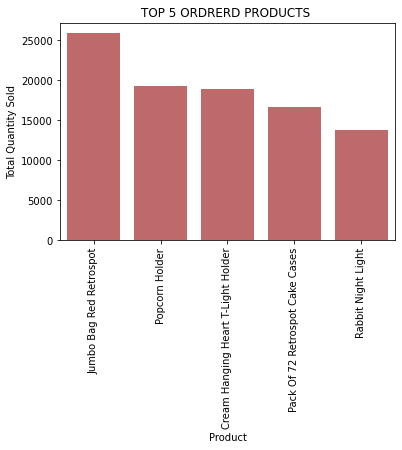

In [99]:
product_preferred(Champions, 'ProductName', 'Quantity')

# 5 Most Cancelled Products

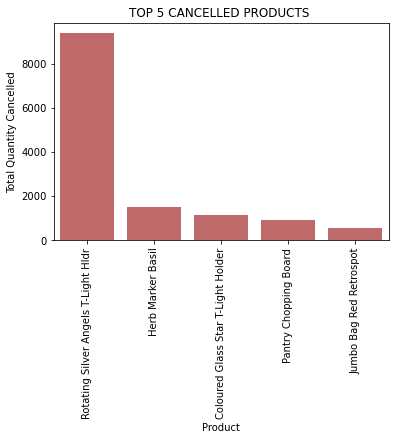

In [100]:
product_cancelled(Champions, 'ProductName', 'Quantity')

# 2. Loyal customer

# Top 5 Preferred Products

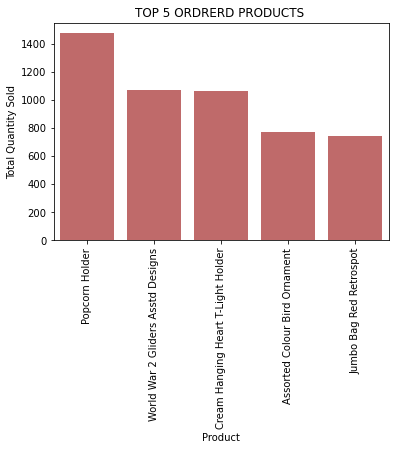

In [101]:
product_preferred(Loyal_customer, 'ProductName', 'Quantity')

# 5 Most Cancelled Products

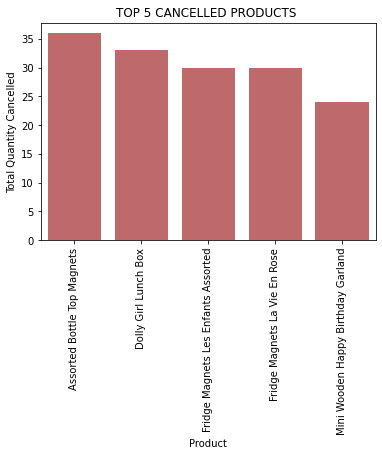

In [102]:
product_cancelled(Loyal_customer, 'ProductName', 'Quantity')

# 3. Potential loyalist

# Top 5 Preferred Products

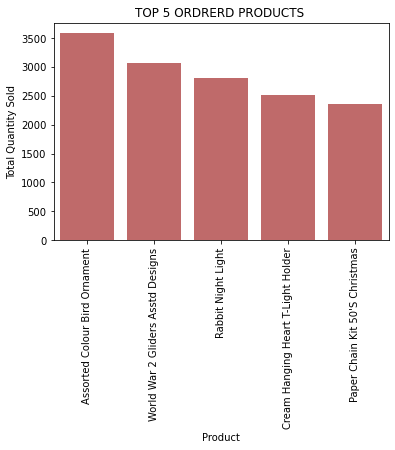

In [103]:
product_preferred(Potential_loyalist, 'ProductName', 'Quantity')

# 5 Most Cancelled Products

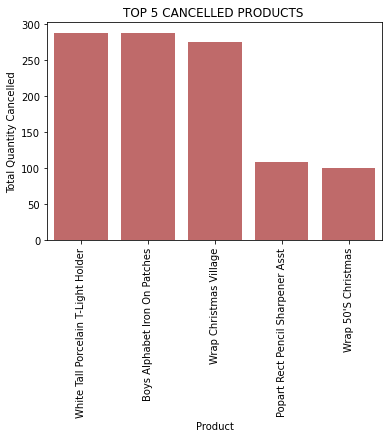

In [104]:
product_cancelled(Potential_loyalist, 'ProductName', 'Quantity')

# 4. Potential champions

# Top 5 Preferred Products

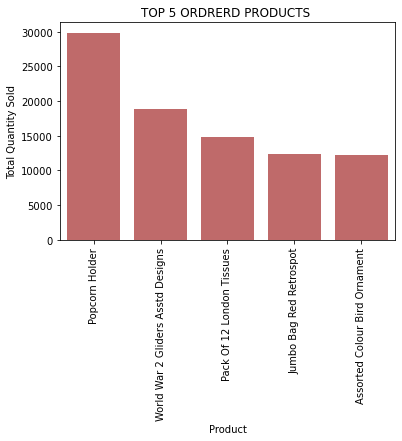

In [105]:
product_preferred(Potential_champions, 'ProductName', 'Quantity')

#  5 Most Cancelled Products

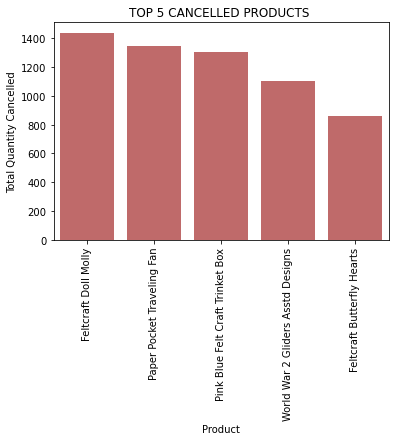

In [106]:
product_cancelled(Potential_champions, 'ProductName', 'Quantity')

# 5. Recent customer

# Top 5 Preferred Products

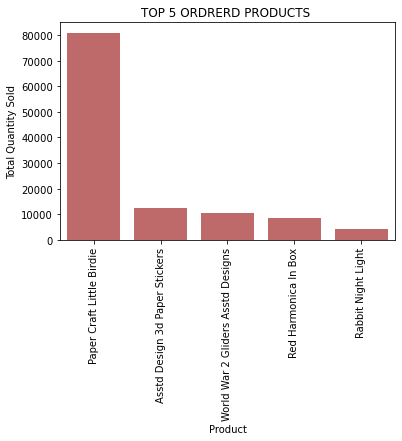

In [107]:
product_preferred(Recent_customer, 'ProductName', 'Quantity')

# 5 Most Cancelled Products

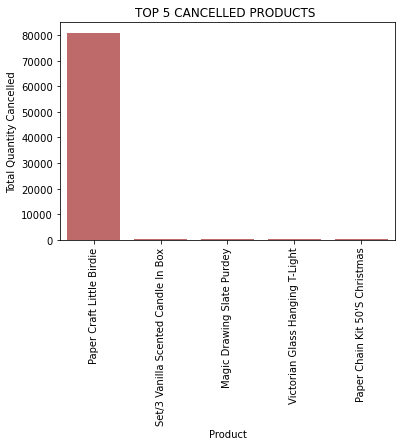

In [108]:
product_cancelled(Recent_customer, 'ProductName', 'Quantity')

# 6. Need attention

# Top 5 Preferred Products 

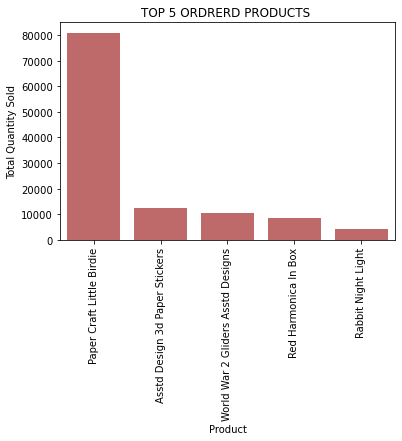

In [109]:
product_preferred(Recent_customer, 'ProductName', 'Quantity')

# 5 Most Cancelled Products

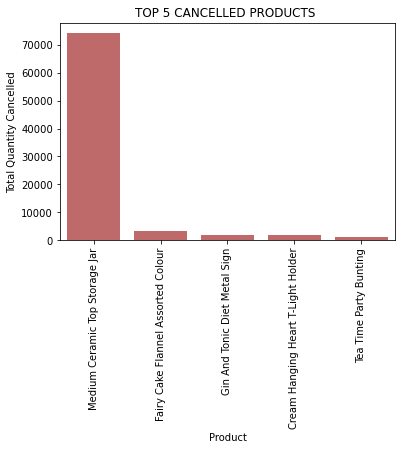

In [110]:
product_cancelled(Need_attention, 'ProductName', 'Quantity')

# 7. At risk

# Top 5 Preferred Products 

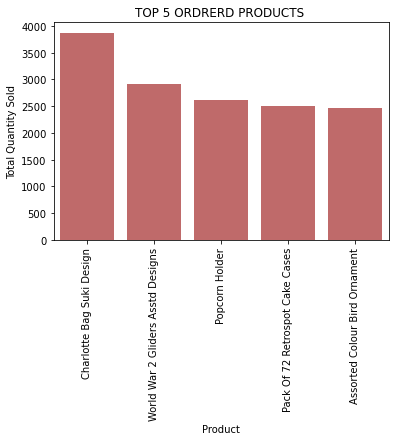

In [111]:
product_preferred(At_risk, 'ProductName', 'Quantity')

# 5 Most Cancelled Products

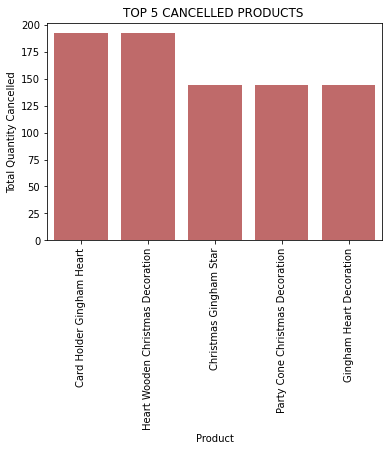

In [112]:
product_cancelled(At_risk, 'ProductName', 'Quantity')

# RETENTION RATE ANALYSIS

# Overview of DataFrame

In [117]:
Transactions.head(3)

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Day_name_of_month,Day_as_integer,Day_of_month,Month_of_the_year,Month_name,Year,Week_of_the_year,Amount_Spent,Cancelled
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,Monday,0,9,12,December,2019,50,257.64,completed
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,Monday,0,9,12,December,2019,50,383.40,completed
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,Monday,0,9,12,December,2019,50,138.36,completed


# Feature Engineering

In [118]:
# Customer start date 

Transactions['Start_Date'] = Transactions.groupby('CustomerNo')['Date'].transform('min')

Transactions

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Day_name_of_month,Day_as_integer,Day_of_month,Month_of_the_year,Month_name,Year,Week_of_the_year,Amount_Spent,Cancelled,Start_Date
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,Monday,0,9,12,December,2019,50,257.64,completed,2019-06-16
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,Monday,0,9,12,December,2019,50,383.40,completed,2018-12-05
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,Monday,0,9,12,December,2019,50,138.36,completed,2018-12-05
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom,Monday,0,9,12,December,2019,50,127.80,completed,2018-12-05
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom,Monday,0,9,12,December,2019,50,71.64,completed,2018-12-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536345,C536548,2018-12-01,22168,Organiser Wood Antique White,18.96,-2,12472.0,Germany,Saturday,5,1,12,December,2018,48,-37.92,cancelled,2018-12-01
536346,C536548,2018-12-01,21218,Red Spotty Biscuit Tin,14.09,-3,12472.0,Germany,Saturday,5,1,12,December,2018,48,-42.27,cancelled,2018-12-01
536347,C536548,2018-12-01,20957,Porcelain Hanging Bell Small,11.74,-1,12472.0,Germany,Saturday,5,1,12,December,2018,48,-11.74,cancelled,2018-12-01
536348,C536548,2018-12-01,22580,Advent Calendar Gingham Sack,16.35,-4,12472.0,Germany,Saturday,5,1,12,December,2018,48,-65.40,cancelled,2018-12-01


In [119]:
# Month of start date

Transactions['Start_Date_Month'] = Transactions['Start_Date'].dt.strftime('%Y-%m')

Transactions

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Day_name_of_month,Day_as_integer,Day_of_month,Month_of_the_year,Month_name,Year,Week_of_the_year,Amount_Spent,Cancelled,Start_Date,Start_Date_Month
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,Monday,0,9,12,December,2019,50,257.64,completed,2019-06-16,2019-06
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,Monday,0,9,12,December,2019,50,383.40,completed,2018-12-05,2018-12
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,Monday,0,9,12,December,2019,50,138.36,completed,2018-12-05,2018-12
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom,Monday,0,9,12,December,2019,50,127.80,completed,2018-12-05,2018-12
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom,Monday,0,9,12,December,2019,50,71.64,completed,2018-12-05,2018-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536345,C536548,2018-12-01,22168,Organiser Wood Antique White,18.96,-2,12472.0,Germany,Saturday,5,1,12,December,2018,48,-37.92,cancelled,2018-12-01,2018-12
536346,C536548,2018-12-01,21218,Red Spotty Biscuit Tin,14.09,-3,12472.0,Germany,Saturday,5,1,12,December,2018,48,-42.27,cancelled,2018-12-01,2018-12
536347,C536548,2018-12-01,20957,Porcelain Hanging Bell Small,11.74,-1,12472.0,Germany,Saturday,5,1,12,December,2018,48,-11.74,cancelled,2018-12-01,2018-12
536348,C536548,2018-12-01,22580,Advent Calendar Gingham Sack,16.35,-4,12472.0,Germany,Saturday,5,1,12,December,2018,48,-65.40,cancelled,2018-12-01,2018-12


In [120]:
# Month of order date

Transactions['OrderDate_Month'] = Transactions['Date'].dt.strftime('%Y-%m')

Transactions

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Day_name_of_month,Day_as_integer,Day_of_month,Month_of_the_year,Month_name,Year,Week_of_the_year,Amount_Spent,Cancelled,Start_Date,Start_Date_Month,OrderDate_Month
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,Monday,0,9,12,December,2019,50,257.64,completed,2019-06-16,2019-06,2019-12
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,Monday,0,9,12,December,2019,50,383.40,completed,2018-12-05,2018-12,2019-12
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,Monday,0,9,12,December,2019,50,138.36,completed,2018-12-05,2018-12,2019-12
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom,Monday,0,9,12,December,2019,50,127.80,completed,2018-12-05,2018-12,2019-12
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom,Monday,0,9,12,December,2019,50,71.64,completed,2018-12-05,2018-12,2019-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536345,C536548,2018-12-01,22168,Organiser Wood Antique White,18.96,-2,12472.0,Germany,Saturday,5,1,12,December,2018,48,-37.92,cancelled,2018-12-01,2018-12,2018-12
536346,C536548,2018-12-01,21218,Red Spotty Biscuit Tin,14.09,-3,12472.0,Germany,Saturday,5,1,12,December,2018,48,-42.27,cancelled,2018-12-01,2018-12,2018-12
536347,C536548,2018-12-01,20957,Porcelain Hanging Bell Small,11.74,-1,12472.0,Germany,Saturday,5,1,12,December,2018,48,-11.74,cancelled,2018-12-01,2018-12,2018-12
536348,C536548,2018-12-01,22580,Advent Calendar Gingham Sack,16.35,-4,12472.0,Germany,Saturday,5,1,12,December,2018,48,-65.40,cancelled,2018-12-01,2018-12,2018-12


In [121]:
#Convert OrderDate month and Start_Date_Month to datetime

Transactions['OrderDate_Month'] = pd.to_datetime(Transactions['OrderDate_Month'])

Transactions['Start_Date_Month'] = pd.to_datetime(Transactions['Start_Date_Month'])

In [122]:
#Calculate days since start date

Transactions['Days_Since_Startday'] = (Transactions['OrderDate_Month'] - Transactions['Start_Date_Month']).dt.days

Transactions.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Day_name_of_month,Day_as_integer,...,Month_of_the_year,Month_name,Year,Week_of_the_year,Amount_Spent,Cancelled,Start_Date,Start_Date_Month,OrderDate_Month,Days_Since_Startday
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,Monday,0,...,12,December,2019,50,257.64,completed,2019-06-16,2019-06-01,2019-12-01,183
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,Monday,0,...,12,December,2019,50,383.40,completed,2018-12-05,2018-12-01,2019-12-01,365
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,Monday,0,...,12,December,2019,50,138.36,completed,2018-12-05,2018-12-01,2019-12-01,365
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom,Monday,0,...,12,December,2019,50,127.80,completed,2018-12-05,2018-12-01,2019-12-01,365
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom,Monday,0,...,12,December,2019,50,71.64,completed,2018-12-05,2018-12-01,2019-12-01,365


In [123]:
#convert days since startday to months by dividing by 30 days (we will take 30 days to make 1 month on average).
#store this as Months_Since_Start_Date .This is Customer Cohort

Transactions['Months_Since_Start_Date'] = Transactions['Days_Since_Startday']/30

Transactions.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Day_name_of_month,Day_as_integer,...,Month_name,Year,Week_of_the_year,Amount_Spent,Cancelled,Start_Date,Start_Date_Month,OrderDate_Month,Days_Since_Startday,Months_Since_Start_Date
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,Monday,0,...,December,2019,50,257.64,completed,2019-06-16,2019-06-01,2019-12-01,183,6.100000
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,Monday,0,...,December,2019,50,383.40,completed,2018-12-05,2018-12-01,2019-12-01,365,12.166667
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,Monday,0,...,December,2019,50,138.36,completed,2018-12-05,2018-12-01,2019-12-01,365,12.166667
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom,Monday,0,...,December,2019,50,127.80,completed,2018-12-05,2018-12-01,2019-12-01,365,12.166667
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom,Monday,0,...,December,2019,50,71.64,completed,2018-12-05,2018-12-01,2019-12-01,365,12.166667


In [124]:
#Round up to whole number

Transactions['Months_Since_Start_Date'] = Transactions['Months_Since_Start_Date'].round()

Transactions.head()

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,Day_name_of_month,Day_as_integer,...,Month_name,Year,Week_of_the_year,Amount_Spent,Cancelled,Start_Date,Start_Date_Month,OrderDate_Month,Days_Since_Startday,Months_Since_Start_Date
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,Monday,0,...,December,2019,50,257.64,completed,2019-06-16,2019-06-01,2019-12-01,183,6.0
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,Monday,0,...,December,2019,50,383.40,completed,2018-12-05,2018-12-01,2019-12-01,365,12.0
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,Monday,0,...,December,2019,50,138.36,completed,2018-12-05,2018-12-01,2019-12-01,365,12.0
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom,Monday,0,...,December,2019,50,127.80,completed,2018-12-05,2018-12-01,2019-12-01,365,12.0
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom,Monday,0,...,December,2019,50,71.64,completed,2018-12-05,2018-12-01,2019-12-01,365,12.0


# Get Customers Who Made Purchase In Same Month

In [125]:

Cohort_Data = Transactions.groupby(['Start_Date_Month','Months_Since_Start_Date'])['CustomerNo'].nunique()

Cohort_Data = Cohort_Data.reset_index()

Cohort_Data


,Start_Date_Month,Months_Since_Start_Date,CustomerNo
0,2018-12-01,0.0,1086
1,2018-12-01,1.0,380
2,2018-12-01,2.0,341
3,2018-12-01,3.0,396
4,2018-12-01,4.0,375
...,...,...,...
86,2019-10-01,1.0,85
87,2019-10-01,2.0,37
88,2019-11-01,0.0,287
89,2019-11-01,1.0,37


In [126]:
Cohort_Data.rename(columns={'CustomerNo':'Customer_Count', 'Start_Date_Month': 'Cohort_Month', \
                            'Months_Since_Start_Date':'Cohort_Index'}, inplace = True)

Cohort_Data

,Cohort_Month,Cohort_Index,Customer_Count
0,2018-12-01,0.0,1086
1,2018-12-01,1.0,380
2,2018-12-01,2.0,341
3,2018-12-01,3.0,396
4,2018-12-01,4.0,375
...,...,...,...
86,2019-10-01,1.0,85
87,2019-10-01,2.0,37
88,2019-11-01,0.0,287
89,2019-11-01,1.0,37


# Result Interpretation:

Cohort_Index = 0.0, Customer_Count = 1086 : means a total of 1086 customers made purchase on 2018-12-01, which is the start month for this analysis  

Cohort_Index = 1.0, Customer_Count = 380 : means out of the customers who made purchase on the Cohort_Month(2018-12-01), 380 customers came back to purchase one month later. 

Cohort_Index = 2.0, Customer_Count = 341 : means out of the customers who made purchase on the Cohort_Month(2018-12-01), 341 customers came back to purchase two month later.

In [127]:
#lets make the pivot table
Cohort_Counts = Cohort_Data.pivot(index = 'Cohort_Month', columns = 'Cohort_Index', values='Customer_Count')

Retention = Cohort_Counts

Retention

Cohort_Index,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
Cohort_Month,,,,,,,,,,,,,
2018-12-01,1086.0,380.0,341.0,396.0,375.0,407.0,397.0,373.0,355.0,412.0,396.0,521.0,275.0
2019-01-01,487.0,107.0,134.0,120.0,151.0,143.0,119.0,120.0,143.0,161.0,169.0,73.0,NaN
2019-02-01,432.0,103.0,80.0,112.0,114.0,99.0,106.0,117.0,106.0,134.0,38.0,NaN,NaN
2019-03-01,492.0,87.0,111.0,98.0,115.0,85.0,125.0,116.0,144.0,46.0,NaN,NaN,NaN
2019-04-01,319.0,69.0,64.0,62.0,64.0,76.0,71.0,83.0,29.0,NaN,NaN,NaN,NaN
2019-05-01,328.0,73.0,61.0,54.0,71.0,76.0,83.0,30.0,NaN,NaN,NaN,NaN,NaN
2019-06-01,267.0,55.0,47.0,60.0,64.0,76.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-01,209.0,36.0,37.0,45.0,64.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-01,172.0,39.0,41.0,41.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Comment:

Now, we shall take the number of customers that came in each month as a base count to calculate percentage retention

In [128]:
Cohort_Size = Cohort_Counts.iloc[:,0]
Cohort_Size.head(3)

Cohort_Month
2018-12-01    1086.0
2019-01-01     487.0
2019-02-01     432.0
Name: 0.0, dtype: float64

# Reshape the data in the interval of 1-0 so we can show a percentage of recurring customers


In [129]:
Retention = Cohort_Counts.divide(Cohort_Size, axis = 0)

Retention_rate = Retention.round(3)*100

In [130]:
Retention_rate.fillna(0, inplace = True)

Retention_rate

Cohort_Index,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
Cohort_Month,,,,,,,,,,,,,
2018-12-01,100.0,35.0,31.4,36.5,34.5,37.5,36.6,34.3,32.7,37.9,36.5,48.0,25.3
2019-01-01,100.0,22.0,27.5,24.6,31.0,29.4,24.4,24.6,29.4,33.1,34.7,15.0,0.0
2019-02-01,100.0,23.8,18.5,25.9,26.4,22.9,24.5,27.1,24.5,31.0,8.8,0.0,0.0
2019-03-01,100.0,17.7,22.6,19.9,23.4,17.3,25.4,23.6,29.3,9.3,0.0,0.0,0.0
2019-04-01,100.0,21.6,20.1,19.4,20.1,23.8,22.3,26.0,9.1,0.0,0.0,0.0,0.0
2019-05-01,100.0,22.3,18.6,16.5,21.6,23.2,25.3,9.1,0.0,0.0,0.0,0.0,0.0
2019-06-01,100.0,20.6,17.6,22.5,24.0,28.5,11.2,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-01,100.0,17.2,17.7,21.5,30.6,10.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-08-01,100.0,22.7,23.8,23.8,12.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Comment:

Retention rate in the first index of each month, 0.0 has 100% as all customers purchased in the first month.

For subsequent index of each month, the rate increased, or decreased based on percent of customers retained after the initial purchase.

Cohort_Index is the index of this table

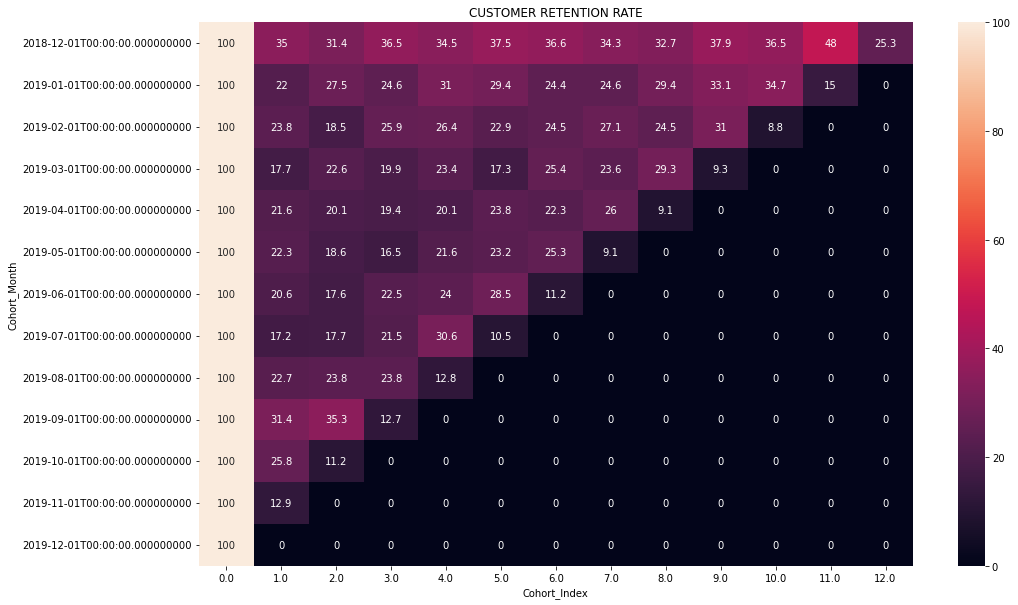

In [131]:
plt.figure(figsize = (16, 10))

sns.heatmap(Retention_rate, annot = True, fmt = 'g')

plt.title('CUSTOMER RETENTION RATE')

plt.show()